<br>

<img src="names.png" width="100%" style="margin-left:auto; margin-right:auto">

<br>

# Project 3 - Classification of Names by Gender

For this project, we will be using the `names` corpora from the `nltk` library.
**Goal** - Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can.  

1. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. 
2. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. 
3. Once you are satisfied with your classifier, check its final performance on the test set.
4. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

<br>

## 0) Preprocessing & EDA of the `names` corpus

The following code will set up the python environment, import the data and perform some light exploratory data analysis.

In [1]:
# libraries used for this analysis
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# load the nltk names corpus
names = nltk.corpus.names

# instantiate lists of 'male' and 'female' names
male_names = names.words( 'male.txt' )
female_names = names.words( 'female.txt' )
print( 'Number of Male Names: ', len( male_names ) )
print( 'Number of Female Names: ', len( female_names ) )

unis = [ w for w in male_names if w in female_names ]
print( 'Number of Unisex names: ', len( unis ) )

Number of Male Names:  2943
Number of Female Names:  5001
Number of Unisex names:  365


<br>

The number of names by gender is not balanced in the dataset. Furthermore, there are a non-trivial number of names that appear as either 'male' or 'female'. The following code will organize the data as a pandas dataframe and visualize number of names by gender...

In [3]:
# reorganize the data as a pandas dataframe
d = {'name': male_names, 'gender': 'male'}
mdf = pd.DataFrame(data=d)
d = {'name': female_names, 'gender': 'female'}
fdf = pd.DataFrame(data=d)
df = pd.concat([mdf,fdf], ignore_index=True)
df.shape

(7944, 2)

In [4]:
# change the 'gender' value for every 'name' that is in the list 'unis'
df.loc[(df.name.isin(unis)),'gender']='unisex'
print( df.shape )

(7944, 2)


In [5]:
print( '#Rows before dropping duplicates: ', df.shape[0] )
df = df.drop_duplicates().reset_index(drop=True)
print( df.shape )
print( '#Rows after dropping duplicates: ', df.shape[0] )

#Rows before dropping duplicates:  7944
(7579, 2)
#Rows after dropping duplicates:  7579


In [6]:
df.gender.value_counts(normalize=True) * 100

female    61.169020
male      34.015042
unisex     4.815939
Name: gender, dtype: float64

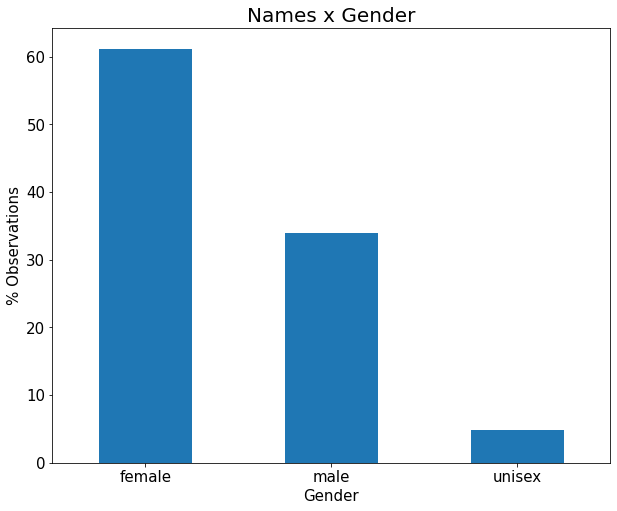

In [7]:
plt.figure(figsize=(10,8))
df['gender'].value_counts(normalize=True).mul(100).round(1).plot(kind='bar', rot=0);
plt.title( 'Names x Gender', fontsize=20)
plt.xlabel( 'Gender' , fontsize=15)
plt.ylabel( '% Observations', fontsize=15)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.show()

In [8]:
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
           'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
           'u', 'v', 'w', 'x', 'y', 'z' ]

mfreq = {key:0 for key in letters}
ffreq = {key:0 for key in letters}
ufreq = {key:0 for key in letters}
fmfreq = {key:0 for key in letters}
fffreq = {key:0 for key in letters}
fufreq = {key:0 for key in letters}


for idx in range( 0, df.shape[0] ):
    last_letter = df['name'][idx].strip()[-1]
    first_letter = df['name'][idx].lower().strip()[0]
    if df['gender'][idx] == 'female':
        ffreq[last_letter] += 1
        fffreq[first_letter] += 1
    elif df['gender'][idx] == 'male':
        mfreq[last_letter] += 1
        fmfreq[first_letter] += 1
    elif df['gender'][idx] == 'unisex':
        ufreq[last_letter] += 1
        fufreq[first_letter] += 1
        
d = {'male': mfreq.values(), 'female': ffreq.values(), 'unisex': ufreq.values()}
lastdf = pd.DataFrame(data=d, index=mfreq.keys())
d = {'male': fmfreq.values(), 'female': fffreq.values(), 'unisex': fufreq.values()}
firstdf = pd.DataFrame(data=d, index=fmfreq.keys())

cols = ['male', 'female', 'unisex']
for col in cols:
    lastdf[col] = round( (lastdf[col] / lastdf[col].sum()) * 100, 2 )
    firstdf[col] = round( (firstdf[col] / firstdf[col].sum()) * 100, 2 )

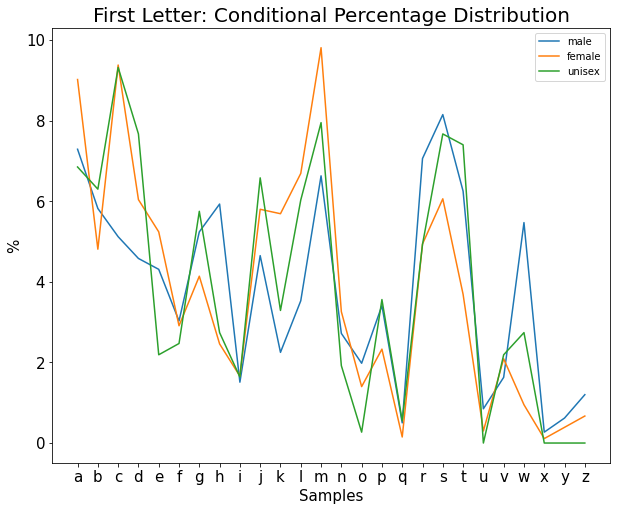

In [9]:
#plt.figure(figsize=(10,8))
firstdf.plot.line(figsize=(10,8))
plt.title( 'First Letter: Conditional Percentage Distribution', fontsize=20)
plt.xlabel( 'Samples' , fontsize=15)
plt.ylabel( '%', fontsize=15)
plt.xticks(ticks = np.arange(0, len(letters), 1.0), labels = letters, fontsize= 15)
plt.yticks(fontsize= 15)
plt.show()

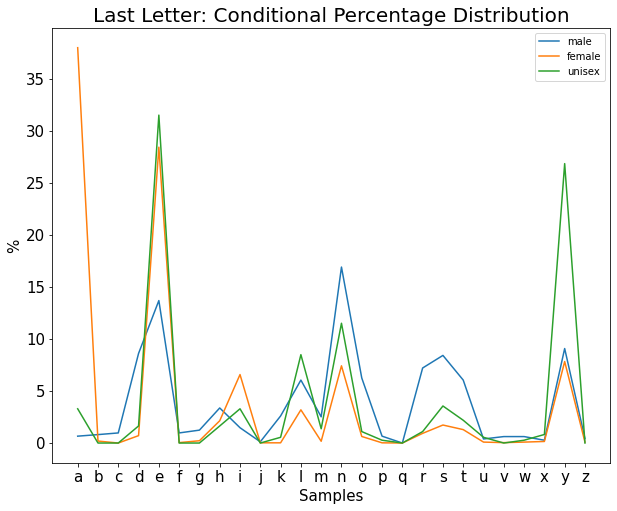

In [10]:
#plt.figure(figsize=(10,8))
lastdf.plot.line(figsize=(10,8))
plt.title( 'Last Letter: Conditional Percentage Distribution', fontsize=20)
plt.xlabel( 'Samples' , fontsize=15)
plt.ylabel( '%', fontsize=15)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.xticks(ticks = np.arange(0, len(letters), 1.0), labels = letters, fontsize= 15)
plt.show()

<br>

From a cursory exploration of the data, we learned that there is a sizable difference between the number of 'female' and 'male' names. Furthermore, there are several hundred names which can be considered either 'unisex'. The data was then organized into a `pandas` dataframe to hold the names in one column and the corresponding gender in another. If a name was considered unisex, the gender label was changed to reflect this and duplicate entries were removed.  

To learn about potential features of gendered names, we then created two visualizations that show the percentage of names for each gender designation that either started or ended with each letter of the alphabet. We were interested in learning about particular patterns in the data that could be uased as features for downstream models. A promising feature would be a letter where either gender designation has a noticeably higher percentage than the others (unisex included). With this in mind, we noticed:  
* Names that start with 'w' are more likely to be male
* Names that end in 'y' are likely to be unisex
* Names that end in 'a' are likely to be female
* Names that end with either 'r', 's', or 't' or more likely to be male

<br>

## 1) Splitting the Names Corpus into three subsets

We will use `sklearn.train_test_split` to split the data into train, devtest and test splits of the data. Additionally, we will opt to `stratify` the data so that the relative class frequencies are approximately preserved across the different data splits.  

The data is to be split a specific way:
* 500 words for the test set
* 500 words for the devtest set
* the remaining 6900 words for the training set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['name'], df['gender'],
                                                    stratify=df['gender'], 
                                                    test_size=500)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train,
                                                    stratify=y_train, 
                                                    test_size=500)

Verify that the sizes of the train, dev and test splits are as expected:

In [12]:
print( 'Train set length: ', X_train.shape[0] )
print( 'Dev set length: ', X_dev.shape[0] )
print( 'Test set length: ', X_test.shape[0] )

Train set length:  6579
Dev set length:  500
Test set length:  500


<br>

## 2) Build and Improve a Gender Classifier

Starting with the example classifier given in chapter 6 of the NLTK book: Natural Language Processing with Python, make incremental improvements. Use the dev-test set to check your progress.  


### Basic Gender Features
The code below shows the example classifier:

In [13]:
# a feature extractor that builds a dictionary containing relevant information (i.e. last letters of the name)
def gender_features( word ):
    return { 'last_letter': word[-1], 'first_letter':word[0], 'length':len( word ) }

In [14]:
train_set = []
for idx in X_train.index:
    train_set.append(( gender_features(X_train[idx]), y_train[idx] ))

In [15]:
classifier = nltk.NaiveBayesClassifier.train( train_set )

In [16]:
print( classifier.classify( gender_features( 'Christopher' ) ) )
print( classifier.classify( gender_features( 'Christine' ) ) )

male
female


In [17]:
dev_set = []
for idx in X_dev.index:
    dev_set.append(( gender_features(X_dev[idx]), y_dev[idx] ))

In [18]:
print( 'Accuracy: ', nltk.classify.accuracy( classifier, dev_set ) )
print( ' ' )
print( classifier.show_most_informative_features( 15 ) )

Accuracy:  0.77
 
Most Informative Features
             last_letter = 'a'            female : male   =     59.2 : 1.0
             last_letter = 'p'              male : female =     19.7 : 1.0
             last_letter = 'v'              male : female =     16.1 : 1.0
             last_letter = 'm'              male : female =     15.8 : 1.0
             last_letter = 'f'              male : female =     14.7 : 1.0
             last_letter = 'd'              male : female =     14.1 : 1.0
             last_letter = 'o'              male : female =      9.2 : 1.0
             last_letter = 'u'            unisex : female =      8.7 : 1.0
             last_letter = 'w'              male : female =      8.5 : 1.0
             last_letter = 'r'              male : female =      7.9 : 1.0
                  length = 2              unisex : female =      6.9 : 1.0
             last_letter = 'k'              male : unisex =      6.0 : 1.0
            first_letter = 'Q'            unisex : femal

### Expanded Gender Features

Here we will build on this approach and extract several more features to distinguish male, female and unisex names

In [19]:
# an expanded feature extractor
def gender_features2( word ):
    return { 'last_letter': word[-1], 
            'first_letter':word[0], 
            'length':len( word ),
            'last 2 letters': word[-2:],
            'first 2 letters': word[:2] }

In [20]:
train_set = []
for idx in X_train.index:
    train_set.append(( gender_features2(X_train[idx]), y_train[idx] ))
    
classifier = nltk.NaiveBayesClassifier.train( train_set )

dev_set = []
for idx in X_dev.index:
    dev_set.append(( gender_features(X_dev[idx]), y_dev[idx] ))
    
print( 'Accuracy: ', nltk.classify.accuracy( classifier, dev_set ) )
print( ' ' )
print( classifier.show_most_informative_features( 15 ) )

Accuracy:  0.77
 
Most Informative Features
          last 2 letters = 'na'           female : male   =    150.1 : 1.0
          last 2 letters = 'ia'           female : male   =     81.3 : 1.0
             last_letter = 'a'            female : male   =     59.2 : 1.0
          last 2 letters = 'ra'           female : male   =     54.6 : 1.0
          last 2 letters = 'rt'             male : female =     50.8 : 1.0
          last 2 letters = 'ta'           female : male   =     39.6 : 1.0
          last 2 letters = 'us'             male : female =     39.6 : 1.0
          last 2 letters = 'io'             male : female =     25.1 : 1.0
          last 2 letters = 'do'             male : female =     23.9 : 1.0
          last 2 letters = 'rd'             male : female =     23.9 : 1.0
          last 2 letters = 'ld'             male : female =     23.5 : 1.0
             last_letter = 'p'              male : female =     19.7 : 1.0
          last 2 letters = 'os'             male : femal

By adding to the feature extractor we were able to increase the accuracy of the predictions on the dev_set from 77.6% to 79%. In comparing the output of the most informative features, we see that adding the `last 2 letters` for the had a greater impact than `first 2 letters`

<br>

### A very different approach...

Option 1: we could try to add more and more features to the feature extractor.  
Option 2: we could try different multinomial classifiers.  
However: let's try an entirely different approach all together!  

We would like to try to perform a classification using the embeddings generated with a pre-trained 🤗 transformers model.  

**Basic example: using CharacterBERT for binary classification**

In [43]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from character_bert.modeling.character_bert import CharacterBertModel
from character_bert.utils.character_cnn import CharacterIndexer
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import time
from transformers import AdamW
from sklearn.metrics import classification_report

In [22]:
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=3) # 3 posible gender name labels
model = BertForSequenceClassification(config=config)

In [23]:
#now replace bert with character bert embeddings 
character_bert_model = CharacterBertModel.from_pretrained('./character_bert/pretrained-models/general_character_bert/')
model.bert = character_bert_model

BERT and BERTlike transformers models use WordPiece for text sequence tokenizations. A crucial difference betweer BERT and CharacterBERT is that CharacterBERT replaces WordPiece with a CharacterCNN. The combined use of CharacterIndexer and the CharacterCNN results in tokenization of the text input by character.

In [24]:
model.bert.embeddings.word_embeddings  # wordpieces are replaced with a CharacterCNN

CharacterCNN(
  (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
  (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
  (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
  (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
  (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
  (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
  (_highways): Highway(
    (_layers): ModuleList(
      (0): Linear(in_features=2048, out_features=4096, bias=True)
      (1): Linear(in_features=2048, out_features=4096, bias=True)
    )
  )
  (_projection): Linear(in_features=2048, out_features=768, bias=True)
)

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
#format the train dataset
y_facttrain, uniq = pd.factorize(y_train) #convert strings to label encodings
X = X_train.tolist()
tokenized_train = [tokenizer.basic_tokenizer.tokenize(text) for text in X] #have used basic tokenizer, other tokenizers can also be used

In [27]:
#format the dev dataset
y_factdev, uniq = pd.factorize(y_dev) #convert strings to label encodings
X_dev = X_dev.tolist()
tokenized_dev = [tokenizer.basic_tokenizer.tokenize(text) for text in X_dev] #have used basic tokenizer, other tokenizers can also be used

In [28]:
indexer = CharacterIndexer()  # This converts each token into a list of character indices
input_tensor_train = indexer.as_padded_tensor(tokenized_train)
input_tensor_dev = indexer.as_padded_tensor(tokenized_dev)

In [29]:
batch_size = 32

y_facttrain, y_factdev = torch.tensor(y_facttrain), torch.tensor(y_factdev)
train_data = TensorDataset(input_tensor_train, y_facttrain)
train_dataloader = DataLoader(train_data,batch_size=batch_size)

val_data = TensorDataset(input_tensor_dev, y_factdev)
val_dataloader = DataLoader(val_data,batch_size=batch_size)

In [30]:
# if available, use GPU else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

In [40]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [41]:
epochs = 3
train_loss_set = []

for _ in trange(epochs, desc="Epoch"):
    
  start_time = time.time()

  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)  
    b_input_ids, b_labels = batch
    
    optimizer.zero_grad()  
    outputs = model(b_input_ids)[0]    
    loss = loss_fn(outputs,b_labels)
    train_loss_set.append(loss.item())    
    
    loss.backward()
    optimizer.step()    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
    
  end_time = time.time()
  print(epoch_time(start_time,end_time))
  print("\nTrain loss: {}".format(tr_loss/nb_tr_steps))

Epoch:  33%|███▎      | 1/3 [02:03<04:07, 123.57s/it]

(2, 3)

Train loss: 0.2283662238058824


Epoch:  67%|██████▋   | 2/3 [04:05<02:02, 122.85s/it]

(2, 2)

Train loss: 0.13915406138572878


Epoch: 100%|██████████| 3/3 [06:07<00:00, 122.64s/it]

(2, 1)

Train loss: 0.0916080219711819


In [42]:
preds = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(val_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch    
        outputs = model(b_input_ids)[0]
        prediction = torch.argmax(outputs,dim=1)
        preds.append(prediction)
        total += b_labels.size(0)
        correct+=(prediction==b_labels).sum().item()

In [65]:
final_preds = []
for tensor in preds:
    for pred in tensor:
        final_preds.append(int(pred))
        
final_preds = ['female' if i == 0 else 
               'male' if i == 1 else 
               'unisex' if i == 2 else 
                   i for i in final_preds]
        
print(classification_report(y_dev,final_preds))

              precision    recall  f1-score   support

      female       0.91      0.93      0.92       306
        male       0.86      0.87      0.86       170
      unisex       0.50      0.29      0.37        24

    accuracy                           0.88       500
   macro avg       0.76      0.70      0.72       500
weighted avg       0.87      0.88      0.88       500

